Students:

Enrico Fazzi - 2003876

Massimo Coppotelli - 1705325

# Vision project: Diabethic Retinopathy Detection and Classification


###Importing libraries

In [1]:
import pandas as pd 
import os 
import numpy as np 
from tqdm import tqdm
from keras_preprocessing import image
import random
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import cv2 as cv2
from skimage import io


from torch.utils import data  
import torch 
from torch import nn 
from torch import optim 
import torchvision  
import torch.nn.functional as F 
from torchvision import datasets, transforms, models
from torchvision.utils import save_image
import torchvision.models as models 
from torch.utils.data.sampler import SubsetRandomSampler 
from torch.utils.data import Dataset, DataLoader 
from torch.optim import lr_scheduler 
from sklearn.metrics import f1_score

import time
from joblib import Parallel, delayed
import joblib

from PIL import Image 

### Loading Data

In [25]:
# importing data from drive

from google.colab import drive
drive.mount('/content/drive')
train_csv = pd.read_csv('/content/drive/My Drive/VP/train.csv')


base_dir = "/content/drive/My Drive/VP"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
#splitting the training set in this way: 0.6 train, 0.2 valid, 0.2 test

valid_size = 0.2 #valid size is equal to test size
num_train = len(train_csv) 
indices = list(range(num_train)) #creates a list within the range of the number of training
np.random.shuffle(indices) # it reorders randomly the indices in the list
split1 = int(np.floor(valid_size * num_train))    # split is an integer values, floor(x) è la parte intera di x
split2 = 2*split1
train_idx, valid_idx, test_idx = indices[split2:], indices[split1:split2], indices[:split1]   # divides the two sets in training and validation according to split


In [27]:
csvfile = open('/content/drive/My Drive/VP/train.csv', 'r').readlines()



with open('/content/drive/My Drive/VP/train1.csv', 'w') as training_csv:
  for line in train_idx:
    training_csv.write(csvfile[line])

with open('/content/drive/My Drive/VP/validation1.csv', 'w') as validation_csv:
  for line in valid_idx:
    validation_csv.write(csvfile[line])

with open('/content/drive/My Drive/VP/test1.csv', 'w') as test_csv:
  for line in test_idx:
    test_csv.write(csvfile[line])

In [28]:
training_csv = pd.read_csv('/content/drive/My Drive/VP/train1.csv')
validation_csv = pd.read_csv('/content/drive/My Drive/VP/validation1.csv')
test_csv = pd.read_csv('/content/drive/My Drive/VP/test1.csv')

In [29]:
# initialization of the dataset we will work on

class OurDataset (Dataset): 
  def __init__(self,csv_values,root_dir = '/content/drive/My Drive', transform= None):
    super().__init__()
    self.values =csv_values.values
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    return len(self.values)

  def  __getitem__(self,index):
    img_name,label = self.values[index]
    img_path = os.path.join (self.root_dir, img_name+'.png')
    image = cv2.imread(img_path)

    if self.transform is not None:
      image = self.transform(image)

    return image,label 

### Data Processing

Definition of training set and image transformations

In [30]:
train_transforms = transforms.Compose([
    transforms.ToPILImage(), # all transformations work on this format
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.25),
    transforms.ColorJitter(brightness=0.25, contrast=0.1),
    #transforms.RandomRotation(degrees=20),
    #transforms.RandomVerticalFlip(p=0.1),
    transforms.RandomGrayscale(p = 0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)) # (val - mean) / std
])

In [31]:
# for data augmentation
train_transforms_1 = transforms.Compose([ 
    transforms.ToPILImage(), # all transformations work on this format
    transforms.Resize((224, 224)),
    #transforms.RandomHorizontalFlip(p=0.25),
    #transforms.ColorJitter(brightness=0.25, contrast=0.1),
    transforms.RandomRotation(degrees=20),
    #transforms.RandomVerticalFlip(p=0.1),
    transforms.RandomGrayscale(p = 0.32),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)) # (val - mean) / std
])

In [32]:
#validation and test transformations
test_transforms = transforms.Compose([
    transforms.ToPILImage(), # all transformations work on this format
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)) # (val - mean) / std
])

In [33]:
train_dataset = OurDataset (csv_values = training_csv, root_dir = '/content/drive/My Drive/VP/train_images/', transform = train_transforms)
#train_dataset = train_dataset + OurDataset (csv_values = train_csv, root_dir = '/content/drive/My Drive/VP/train_images/', transform = train_transforms_1)
validation_dataset = OurDataset (csv_values = validation_csv, root_dir = '/content/drive/My Drive/VP/train_images/', transform = test_transforms)
test_dataset = OurDataset (csv_values = test_csv, root_dir = '/content/drive/My Drive/VP/train_images/', transform = test_transforms)

### Defining the three sets we will use to train and test our models

In [38]:
batch_size=64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = False)
valid_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = batch_size)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size)

## Importing architectures

In [ ]:
# working on GPU

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print('CUDA is not available. Training on CPU ...')
else:
  print('CUDA is available! Training on GPU ...')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA is available! Training on GPU ...


#### Resnet 152


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#model = models.resnet152(pretrained=True) # we are using a resnet152
#num_ftrs = model.fc.in_features # with preset features
#out_ftrs = 5 # and 5 output features corresponding to the 5 classes

# we will use a sequential fully connected network defined here

#model.fc = nn.Sequential(nn.Linear(num_ftrs, 512),nn.ReLU(),nn.Linear(512,out_ftrs),nn.LogSoftmax(dim=1)) #linear classifier

model = joblib.load('/content/drive/MyDrive/VP/model.pkl') ###uncomment when already working with a fine-tuned ResNet

criterion = nn.NLLLoss() # negative log likelyhood loss function, useful for class. problems
optimizer = torch.optim.Adam(filter(lambda p:p.requires_grad,model.parameters()) , lr = 0.0001,weight_decay=0.05)  # Adam optimizer stochastic gradient descent

scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1) # adaptive learning rate
model.to(device);



In [ ]:
#save the model to re-use it

model_save_name = "classifier.pt"
path = F"/content/drive/My Drive/VP/{model_save_name}"

In [11]:
# to unfreeze more layers --- Fine-tuning

for name,child in model.named_children():
  if name in ['layer2','layer3','layer4','fc']:
    print(name + 'is unfrozen')
    for param in child.parameters():
      param.requires_grad = True
  else:
    print(name + 'is frozen')
    for param in child.parameters():
      param.requires_grad = False

optimizer = torch.optim.Adam(filter(lambda p:p.requires_grad,model.parameters()) , lr = 0.0001, weight_decay=0.05)  # Adam optimizer stochastic gradient descent
lambda1 = lambda epoch: 0.65 ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

conv1is frozen
bn1is frozen
reluis frozen
maxpoolis frozen
layer1is frozen
layer2is unfrozen
layer3is unfrozen
layer4is unfrozen
avgpoolis frozen
fcis unfrozen


In [12]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

#### GoogleNet

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.googlenet(pretrained=True) # we are using a GoogleNet
dropout= 0.1 #set dropout
num_ftrs = model.fc.in_features # with preset features
out_ftrs = 5 # and 5 output features corresponding to the 5 classes

# we will use a sequential fully connected network defined here

model.fc = nn.Sequential(nn.Linear(num_ftrs, 512),nn.ReLU(),nn.Linear(512, out_ftrs),nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss() # negative log likelyhood loss function, useful for class. problems
optimizer = torch.optim.Adam(filter(lambda p:p.requires_grad,model.parameters()) , lr = 0.0001, weight_decay=0.0001)  # Adam optimizer stochastic gradient descent

scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1) # adaptive learning rate
model.to(device);


In [15]:
#save the model to re-use it

model_save_name = "classifier.pt"
path = F"/content/drive/My Drive/VP/{model_save_name}"

In [19]:
# to unfreeze more layers --- Fine-tuning the model

for name,child in model.named_children():
  if name in ['inception5a','inception5b','avgpool','dropout','fc']:
    print(name + 'is unfrozen')
    for param in child.parameters():
      param.requires_grad = True
  else:
    print(name + 'is frozen')
    for param in child.parameters():
      param.requires_grad = False

optimizer = torch.optim.Adam(filter(lambda p:p.requires_grad,model.parameters()) , lr = 0.0001, weight_decay = 0.0001)  # Adam optimizer stochastic gradient descent
lambda1 = lambda epoch: 0.65 ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

conv1is frozen
maxpool1is frozen
conv2is frozen
conv3is frozen
maxpool2is frozen
inception3ais frozen
inception3bis frozen
maxpool3is frozen
inception4ais frozen
inception4bis frozen
inception4cis frozen
inception4dis frozen
inception4eis frozen
maxpool4is frozen
inception5ais unfrozen
inception5bis unfrozen
avgpoolis unfrozen
dropoutis unfrozen
fcis unfrozen


In [20]:
#printing the model
model 

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

#### EfficientNet

In [2]:
# installing the architecture 

!pip install efficientnet_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=0ecb35e6c188064ce42f408c1343eeba4467b03a94fa144b332a2ab058d004dd
  Stored in directory: /root/.cache/pip/wheels/84/b9/90/25a0195cf95fb5533db96f1c77ea3f296b7cc86ae8ae48e3dc
Successfully built efficientnet_pytorch


In [6]:
# importing EfficientNet-b7
from efficientnet_pytorch import EfficientNet

out_ftrs = 5 #5 output features corresponding to the 5 classes

model = EfficientNet.from_pretrained('efficientnet-b7', num_classes=out_ftrs)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")




dropout= 0.01
num_ftrs =  model._fc.in_features 

# defining the fully connected layers-- Final Classifier

model._fc = nn.Sequential(nn.Linear(num_ftrs, 1280),nn.Linear(1280, out_ftrs),nn.LogSoftmax(dim=1)) 



criterion = nn.NLLLoss() # negative log likelyhood loss function, useful for class. problems
optimizer = torch.optim.Adam(filter(lambda p:p.requires_grad,model.parameters()) , lr = 0.01, weight_decay = 0.01)  # Adam optimizer stochastic gradient descent

scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1) # adaptive learning rate
model.to(device);


Loaded pretrained weights for efficientnet-b7


In [ ]:
#save the model to re-use it

model_save_name = "classifier.pt"
path = F"/content/drive/My Drive/VP/{model_save_name}"

In [8]:
# to unfreeze more layers --- Fine-tuning

for name,child in model.named_children():
  if name in ['_dropout','_fc','_swish']:
    print(name + 'is unfrozen')
    for param in child.parameters():
      param.requires_grad = True
  else:
    print(name + 'is frozen')
    for param in child.parameters():
      param.requires_grad = False


optimizer = torch.optim.Adam(filter(lambda p:p.requires_grad,model.parameters()) , lr = 0.01, weight_decay = 0.01)  # Adam optimizer stochastic gradient descent
lambda1 = lambda epoch: 0.65 ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

_conv_stemis frozen
_bn0is frozen
_blocksis frozen
_conv_headis frozen
_bn1is frozen
_avg_poolingis frozen
_dropoutis unfrozen
_fcis unfrozen
_swishis unfrozen


In [9]:
# outputting the whole model
model

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 64, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        64, 64, kernel_size=(3, 3), stride=[1, 1], groups=64, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        64, 16, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        16, 64, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False
  

### Loading the model

In [ ]:
# to resume the model training later

def load_model(path):
  checkpoint = torch.load(path)
  model.load_state_dict(checkpoint['model_state_dict']) #checkpoint loading the saved state of the model
  optimizer.load_state_dict(checkpoint['optimizer_state_dict']) #checkpoint loading the saved state of the optimizer
  return model
model = load_model("/content/drive/My Drive/VP/classifier.pt") # loading the model

## Training on Training and Validation Set

In [ ]:
num_epochs = 10   #number of epochs
train_loss , validation_loss, acc, f1_s_array = [] , [], [], [] 
valid_loss_min = np.Inf 
t1 = time.perf_counter() # to quantify training time


model.train()
print("Model Training started.....")

for epoch in range(num_epochs):
  current_loss = 0
  batch = 0
  f1_s_list =  []  # to compute f1-score

  for images,labels in train_loader:
    images,labels = images.to(device), labels.to(device)

    outputs = model(images) #forward
    f1_s = f1_score(np.array(labels.to('cpu')),np.array(torch.argmax(outputs, dim = 1).to('cpu')), labels = list(range(5)),average = 'macro', zero_division = 0) #f1 score macro considers each class equally, micro is weighted according to the weight
    print(f1_s)
    f1_s_list.append(f1_s)
    loss = criterion(outputs,labels)
    optimizer.zero_grad()

    loss.backward() #backward
    optimizer.step()

    current_loss += loss.item()
    batch += 1

    if batch % 10 == 0:  
     print(f" epoch {epoch + 1} batch {batch} completed") 

  valid_l = 0
  accuracy = 0
  F1_Score = 0

  print('Training f1-score is {:.10f}:'.format(sum(f1_s_list)/len(f1_s_list)))

  # evaluation on validation set
  with torch.no_grad():
      f1_s_valid = []
      print(f"validation started for {epoch + 1}")
      model.eval() 

      for images,labels in valid_loader:
          images,labels = images.to(device), labels.to(device)

          log_output_val = model(images)
          f1_s = f1_score(np.array(labels.to('cpu')),np.array(torch.argmax(log_output_val, dim = 1).to('cpu')), labels = list(range(5)),average = 'macro', zero_division = 0) #f1 score macro cosndiers each class equally, micro is weighted according to the weight
          print(f1_s)
          f1_s_valid.append(f1_s) 
          valid_l += criterion(log_output_val,labels) #validation loss
          output_val = torch.exp(log_output_val)
          top_output , top_output_class = output_val.topk(1,dim=1)
          n_corrects = (top_output_class == labels.view(*top_output_class.shape))

          accuracy += torch.mean(n_corrects.type(torch.FloatTensor))

  print('Validation f1-score is {:.10f}:'.format(sum(f1_s_valid)/len(f1_s_valid)))

  # to plot f1 and accuracy values wrt the number of epochs
  x = sum(f1_s_valid)/len(f1_s_valid)
  f1_s_array.append(x) 
  train_loss.append(current_loss/len(train_loader))
  validation_loss.append(valid_l/len(valid_loader))
  acc.append(accuracy//len(valid_loader))

  scheduler.step()

  print("Epoch: {}/{}.. ".format(epoch+1, num_epochs),"Training Loss: {:.3f}.. ".format(current_loss/len(train_loader)),"Valid Loss: {:.3f}.. ".format(valid_l/len(valid_loader)),
        "Valid Accuracy: {:.3f}".format(accuracy/len(valid_loader)))
  
 #the training loop will restart
  model.train() 

 # if we have an improvement we save the parameters of the model

  if valid_l/len(valid_loader) <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_l/len(valid_loader))) 
        torch.save({
            'epoch': epoch,
            'model': model,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': valid_loss_min
            }, path)
        valid_loss_min = valid_l/len(valid_loader)  
  # priniting time needed to train and evaluate       
  t2 = time.perf_counter()
  print('time taken to run:',t2-t1)
  #completed training
  print('Training Completed Succesfully !')    





In [ ]:
# Save the model as a pickle in a file
joblib.dump(model, '/content/drive/MyDrive/VP/model.pkl') #useful for future retraining

### Plotting accuracy and f1-score

In [ ]:
# wrt the number of training epochs

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.xlim([1, 10])
plt.ylim([0, 1])
plt.plot(acc, label='accuracy')
plt.plot(f1_s_array, label='f1-score')
plt.legend("")
plt.xlabel("Epochs") #x: number of epochs
plt.legend(frameon=False)


## Training on Training and Validation sets + Test scores

In [39]:
train_dataset = OurDataset (csv_values = training_csv, root_dir = '/content/drive/My Drive/VP/train_images/', transform = train_transforms)
#train_dataset = train_dataset + OurDataset (csv_values = train_csv, root_dir = '/content/drive/My Drive/VP/train_images/', transform = train_transforms_1)
validation_dataset = OurDataset (csv_values = validation_csv, root_dir = '/content/drive/My Drive/VP/train_images/', transform = train_transforms)

train_dataset = train_dataset + validation_dataset

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = False)


In [ ]:
# retraining on the new training set and evaluating on test set
num_epochs = 15
train_loss , test_loss, acc = [] , [], []
test_loss_min = np.Inf 
t1 = time.perf_counter()
f1_array = []


# Load the model from the file
#model = joblib.load('/content/drive/MyDrive/VP/model.pkl') 
  
model.train()
print("Model Training started.....")

for epoch in range(num_epochs):
  current_loss = 0
  batch = 0
  f1_s_list =  []

  for images,labels in train_loader:
    images,labels = images.to(device), labels.to(device)
    outputs = model(images) #forward

    f1_s = f1_score(np.array(labels.to('cpu')),np.array(torch.argmax(outputs, dim = 1).to('cpu')), labels = list(range(5)),average = 'macro', zero_division = 0) #f1 score macro cosndiers each class equally, micro is weighted according to the weight
    f1_s_list.append(f1_s)
    loss = criterion(outputs,labels)
    optimizer.zero_grad()

    loss.backward() #backward
    optimizer.step()

    current_loss += loss.item()
    batch += 1

    if batch % 10 == 0:
     print(f" epoch {epoch + 1} batch {batch} completed") 

  test_l = 0
  accuracy = 0
  F1_Score = 0

  print('Training f1-score is {:.10f}:'.format(sum(f1_s_list)/len(f1_s_list)))

# evaluating on test set
  with torch.no_grad():
      f1_s_test = []
      print(f"test started for {epoch + 1}")
      model.eval() 

      for images,labels in test_loader:
          images,labels = images.to(device), labels.to(device)

          log_output_val = model(images)
          f1_s = f1_score(np.array(labels.to('cpu')),np.array(torch.argmax(log_output_val, dim = 1).to('cpu')), labels = list(range(5)),average = 'macro', zero_division = 0) #f1 score macro cosndiers each class equally, micro is weighted according to the weight
          print(f1_s)
          f1_s_test.append(f1_s) 
          test_l += criterion(log_output_val,labels) 
          output_val = torch.exp(log_output_val)
          top_output , top_output_class = output_val.topk(1,dim=1)
          n_corrects = (top_output_class == labels.view(*top_output_class.shape))

          accuracy += torch.mean(n_corrects.type(torch.FloatTensor))

  print('Test f1-score is {:.10f}:'.format(sum(f1_s_test)/len(f1_s_test)))

  # to plot the scores
  f1_array.append(sum(f1_s_test)/len(f1_s_test))
  test_loss.append(test_l/len(valid_loader))
  acc.append(accuracy/len(test_loader))

  scheduler.step()

  print("Epoch: {}/{}.. ".format(epoch+1, num_epochs),"Training Loss: {:.3f}.. ".format(current_loss/len(train_loader)),"Test Loss: {:.3f}.. ".format(test_l/len(test_loader)),
        "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))
      
  model.train() 

  # if we have an improvement we save the parameters of the model
  
  if test_l/len(test_loader) <= test_loss_min:
        print('Test loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(test_loss_min,test_l/len(test_loader))) 
        torch.save({
            'epoch': epoch,
            'model': model,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': test_loss_min
            }, path)
        test_loss_min = test_l/len(test_loader)   
  # to print time       
  t2 = time.perf_counter()
  print('time taken to run:',t2-t1)
  #completed training and evaluation
  print('Training Completed Succesfully !')   

# Save the model as a pickle in a file
joblib.dump(model, '/content/drive/MyDrive/VP/model.pkl') 


### Plotting accuracy and F1-Score on Test set

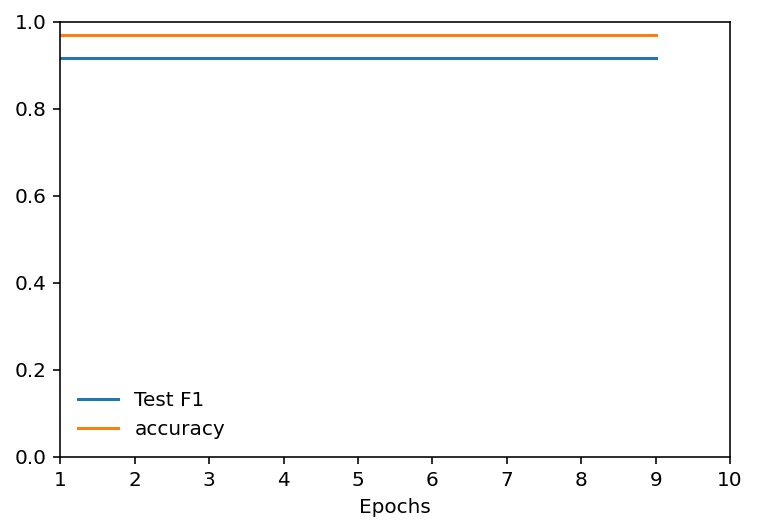

In [41]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(f1_array, label='Test F1')
plt.plot(acc, label='accuracy')
plt.xlim([1, 10])
plt.ylim([0, 1])
plt.legend("")
plt.xlabel("Epochs") #x: number of epochs
plt.legend(frameon=False)

## Εvaluation on Test set

In [40]:
# we just evaluate our model on test set, NO TRAINING

num_epochs = 1
train_loss , test_loss, acc = [] , [], []
test_loss_min = np.Inf 
f1_array = []

for epoch in range(num_epochs):
  current_loss = 0
  batch = 0
  f1_s_list =  []
  test_l = 0
  accuracy = 0
  F1_Score = 0
  with torch.no_grad():
      f1_s_test = []
      print(f"test started for {epoch + 1}")
      model.eval() 

      for images,labels in test_loader:
          images,labels = images.to(device), labels.to(device)

          log_output_val = model(images)
          f1_s = f1_score(np.array(labels.to('cpu')),np.array(torch.argmax(log_output_val, dim = 1).to('cpu')), labels = list(range(5)),average = 'macro', zero_division = 0) #f1 score macro cosndiers each class equally, micro is weighted according to the weight
          f1_s_test.append(f1_s) 
          test_l += criterion(log_output_val,labels) 
          output_val = torch.exp(log_output_val)
          top_output , top_output_class = output_val.topk(1,dim=1)
          n_corrects = (top_output_class == labels.view(*top_output_class.shape))

          accuracy += torch.mean(n_corrects.type(torch.FloatTensor))
          
  print('Test f1-score is {:.10f}:'.format(sum(f1_s_test)/len(f1_s_test)))
  f1_array.append(sum(f1_s_test)/len(f1_s_test))
  test_loss.append(test_l/len(valid_loader))
  acc.append(accuracy/len(test_loader))
  print("Epoch: {}/{}.. ".format(epoch+1, num_epochs),"Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

test started for 1
Test f1-score is 0.9172173606:
Epoch: 1/10..  Test Accuracy: 0.969
test started for 2
Test f1-score is 0.9172173606:
Epoch: 2/10..  Test Accuracy: 0.969
test started for 3
Test f1-score is 0.9172173606:
Epoch: 3/10..  Test Accuracy: 0.969
test started for 4
Test f1-score is 0.9172173606:
Epoch: 4/10..  Test Accuracy: 0.969
test started for 5
Test f1-score is 0.9172173606:
Epoch: 5/10..  Test Accuracy: 0.969
test started for 6
Test f1-score is 0.9172173606:
Epoch: 6/10..  Test Accuracy: 0.969
test started for 7
Test f1-score is 0.9172173606:
Epoch: 7/10..  Test Accuracy: 0.969
test started for 8
Test f1-score is 0.9172173606:
Epoch: 8/10..  Test Accuracy: 0.969
test started for 9
Test f1-score is 0.9172173606:
Epoch: 9/10..  Test Accuracy: 0.969
test started for 10
Test f1-score is 0.9172173606:
Epoch: 10/10..  Test Accuracy: 0.969
